# Data Inspeection & Sanity Check 

This script examines the data and trys to tidy up format error, inconsistant naming, etc


In [40]:
# Load the data with calculated postal code and location coordinates 
import pandas as pd
import os
from pathlib import Path

data_dir = Path("../Dataset")
df_train = pd.read_csv(data_dir / 'train.csv')
# df_train = pd.read_csv(data_dir / 'train_with_hdb_coordinates_and_postal_code.csv')
df_train.head()

,MONTH,TOWN,FLAT_TYPE,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE
0,2020-10,woodlands,4 room,681B,woodlands drive 62,07 to 09,102.0,premium apartment,uncategorized,2000,420000.0
1,2021-07,bishan,4 room,264,bishan street 24,07 to 09,104.0,model a,uncategorized,1992,585000.0
2,2021-05,bukit panjang,4 room,520,jelapang road,19 to 21,102.0,model a,uncategorized,1998,450000.0
3,2021-08,punggol,4 room,121B,edgedale plains,16 to 18,93.0,model a,uncategorized,2017,465000.0
4,2023-05,hougang,5 room,997B,Buangkok Crescent,10 to 12,113.0,improved,uncategorized,2018,710000.0


### 1.1 Strategy for cleaning data
- firstly, check all for duplicates and none values. Remove them 

numerical:
- MONTH: check for invalid value e.g. unrealistic month or time in the future
- BLOCK: check for invalid value e.g. 0
- FLOOR_RANGE: check for invalid value e.g. 0 or negative 
- FLOOR_AREA_SQM: check for too large or small value
- LEASE_COMMENCE: check for invalid years (>99 years or in the future)
- RESALE_PRICE: check for too large or small, 0 or negative value

categorical:
- TOWN: check for format (e.g. upper/lower) and spelling error
- FLAT_TYPE: check for hypened & not hypened 
- STREET: check for format and spelling
- FLAT_MODEL: check for format and spelling
- ECO_CATEGORY: remove since all same value

In [54]:
df = df_train.copy()

# check and remove duplicates 
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

# check and remove null values
df = df.dropna()
print(f"After removing null values: {df.shape}")

Original shape: (162691, 11)
After removing duplicates: (162570, 11)
After removing null values: (162570, 11)


In [55]:
# ----- clean invalid numerical features ------
# check for invalid floor area size and remove outlier
print("clean floor area size")
print(f"min floor area size: {df['FLOOR_AREA_SQM'].min()}")
print(f"max floor area size: {df['FLOOR_AREA_SQM'].max()}")
df = df[(df['FLOOR_AREA_SQM'] > 10) & (df['FLOOR_AREA_SQM'] < 350)]
print(f"after removing biggest floor area size: {df.shape}")

# check for invalid lease commencement year (e.g. future year or too old year)
print("clean lease commencement year")
df = df[(df['LEASE_COMMENCE_DATA'] >= 1900) & (df['LEASE_COMMENCE_DATA'] <= 2024)]
print(f"after removing invalid lease commencement year: {df.shape}")

# check for invalid resale price (e.g. 0 or negative price)
print("clean resale price")
df = df[df['RESALE_PRICE'] > 1000]
print(f"after removing invalid resale price: {df.shape}")


clean floor area size
min floor area size: 31.0
max floor area size: 366.7
after removing biggest floor area size: (162569, 11)
clean lease commencement year
after removing invalid lease commencement year: (162569, 11)
clean resale price
after removing invalid resale price: (162569, 11)


In [58]:

print("clean flat type")
print(f"before: {df['FLAT_TYPE'].unique()}")
df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace(' room', '-room', case=False)
print(f"after: {df['FLAT_TYPE'].unique()}")

print("flat model: extra discription for flat type")
print(f"before: {df['FLAT_MODEL'].unique()}")

# drop ECO_category since it is not useful
print("drop ECO_CATEGORY")
if 'ECO_CATEGORY' in df.columns:
    df = df.drop(columns=['ECO_CATEGORY'])
    print(f"after dropping ECO_CATEGORY: {df.shape}")

# standardise town names to all lower
print("standardise town names")
df['TOWN'] = df['TOWN'].str.lower()
# print(f"town names: {df['TOWN'].unique()}")

# standardise street names to all lower
print("standardise street names")
df['STREET'] = df['STREET'].str.lower()
print(f"sample street names: {df['STREET'].unique()[:10]}")


clean flat type
before: ['4-room' '5-room' '3-room' 'executive' '2-room' '1-room'
 'multi generation']
after: ['4-room' '5-room' '3-room' 'executive' '2-room' '1-room'
 'multi generation']
flat model: extra discription for flat type
before: ['premium apartment' 'model a' 'improved' 'new generation' 'standard'
 'maisonette' 'dbss' 'simplified' 'apartment' 'model a2' 'type s1'
 'adjoined flat' 'model a maisonette' 'type s2' '3gen' '2 room' 'terrace'
 'premium apartment loft' 'premium maisonette' 'multi generation'
 'improved maisonette']
drop ECO_CATEGORY
standardise town names
standardise street names
sample street names: ['woodlands drive 62' 'bishan street 24' 'jelapang road' 'edgedale plains'
 'buangkok crescent' 'clementi avenue 5' 'fajar road'
 'bedok north avenue 4' 'punggol east' 'yishun avenue 4']


# Exploritory Data Analysis - Proximity
This script compares hdb location with all the auxiliary data given to determine which factor(hawkers, mrt, mall, etc) have the most influence over sale price. The comparison uses spearman correlation. 
This will be useful in the later training of models to determine which feature to be added to the model.

In [25]:
# geo_features.py
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

EARTH_RADIUS_KM = 6371.0088

# ---------- helpers ----------
def _to_radians(df, lat_col="LATITUDE", lon_col="LONGITUDE"):
    lat_rad = np.deg2rad(df[lat_col].to_numpy(dtype=float))
    lon_rad = np.deg2rad(df[lon_col].to_numpy(dtype=float))
    return np.c_[lat_rad, lon_rad]

def _build_balltree(poi_df, lat_col="LATITUDE", lon_col="LONGITUDE"):
    coords_rad = _to_radians(poi_df, lat_col, lon_col)
    # Haversine metric expects [lat, lon] in radians; distances returned are in radians
    tree = BallTree(coords_rad, metric="haversine")
    return tree, coords_rad

def _validate_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

# ---------- core: nearest + counts ----------
def compute_nearest_and_counts(
    flats_df: pd.DataFrame,
    poi_df: pd.DataFrame,
    category: str,
    radii_km=(1.0, 2.0),
    k_nearest=1,
    flats_lat_col="LATITUDE",
    flats_lon_col="LONGITUDE",
    poi_lat_col="LATITUDE",
    poi_lon_col="LONGITUDE",
    id_col=None,  # optional stable key to merge on (e.g., BLOCK)
):
    """
    Returns a dataframe with:
      - d_nearest_{category}_km
      - count_{category}_le_{R}km for each R in radii_km
    """
    _validate_columns(flats_df, [flats_lat_col, flats_lon_col])
    _validate_columns(poi_df, [poi_lat_col, poi_lon_col])

    if len(poi_df) == 0:
        # No POIs: return zeros + large distance
        out = pd.DataFrame(index=flats_df.index)
        out[f"d_nearest_{category}_km"] = np.nan
        for R in radii_km:
            out[f"count_{category}_le_{R:.1f}km"] = 0
        if id_col and id_col in flats_df.columns:
            out[id_col] = flats_df[id_col]
        return out

    # Build tree once
    tree, _ = _build_balltree(poi_df, poi_lat_col, poi_lon_col)

    flats_rad = _to_radians(flats_df, flats_lat_col, flats_lon_col)

    # --- nearest distance ---
    # query returns distances in radians; convert to km
    dist_rad, _ = tree.query(flats_rad, k=k_nearest)
    # If k>1, take mean of k nearest to smooth noise
    d_nearest_km = (dist_rad.mean(axis=1)) * EARTH_RADIUS_KM

    # --- counts within radii ---
    counts = {}
    for R in radii_km:
        # radius_neighbors expects radius in radians
        ind = tree.query_radius(flats_rad, r=(R / EARTH_RADIUS_KM))
        counts[R] = np.fromiter((len(ix) for ix in ind), dtype=int, count=len(ind))

    # Assemble result
    out = pd.DataFrame(index=flats_df.index)
    out[f"d_nearest_{category}_km"] = d_nearest_km
    for R, c in counts.items():
        out[f"count_{category}_le_{R:.1f}km"] = c

    if id_col and id_col in flats_df.columns:
        out[id_col] = flats_df[id_col]
    return out

# ---------- batch builder over multiple categories ----------
def add_geo_features(
    flats_df: pd.DataFrame,
    poi_dict: dict,
    radii_km=(1.0, 2.0),
    k_nearest=1,
    flats_lat_col="LATITUDE",
    flats_lon_col="LONGITUDE",
):
    """
    poi_dict: { "primary": primary_df, "secondary": secondary_df, "malls": malls_df, "hawkers": hawkers_df, ... }
    Returns: flats_df joined with new geo features for each category.
    """
    pieces = []
    for cat, poi_df in poi_dict.items():
        feats = compute_nearest_and_counts(
            flats_df=flats_df,
            poi_df=poi_df,
            category=cat,
            radii_km=radii_km,
            k_nearest=k_nearest,
            flats_lat_col=flats_lat_col,
            flats_lon_col=flats_lon_col,
        )
        pieces.append(feats)

    features = pd.concat(pieces, axis=1)
    return pd.concat([flats_df.reset_index(drop=True), features.reset_index(drop=True)], axis=1)

# ---------- correlation EDA ----------
def spearman_corr_vs_price(df: pd.DataFrame, target="RESALE_PRICE", feature_prefixes=("d_nearest_", "count_")):
    """
    Computes Spearman ρ between price and all features starting with given prefixes.
    Returns a tidy dataframe for plotting.
    """
    if target not in df.columns:
        raise ValueError(f"{target} not found in dataframe.")

    feature_cols = [c for c in df.columns if c.startswith(feature_prefixes)]
    rows = []
    y = df[target].to_numpy()

    for col in feature_cols:
        x = df[col].to_numpy()
        # Drop NaNs pairwise
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 10:
            rho = np.nan
            p = np.nan
        else:
            rho, p = spearmanr(x[mask], y[mask])
        rows.append({"feature": col, "spearman_rho": rho, "p_value": p})

    out = pd.DataFrame(rows).sort_values("spearman_rho", key=lambda s: s.abs(), ascending=False)
    return out

def plot_spearman_correlations(corr_df: pd.DataFrame, top_n=20, figsize=(9, 6)):
    """
    Bar plot of top |rho| features (positive up, negative down).
    """
    plot_df = corr_df.head(top_n).iloc[::-1]  # reverse for horizontal plot
    plt.figure(figsize=figsize)
    plt.barh(plot_df["feature"], plot_df["spearman_rho"])
    plt.axvline(0.0, linestyle="--", linewidth=1)
    plt.title("Spearman correlation with RESALE_PRICE (higher |rho| = stronger)")
    plt.xlabel("Spearman ρ")
    plt.tight_layout()
    plt.show()


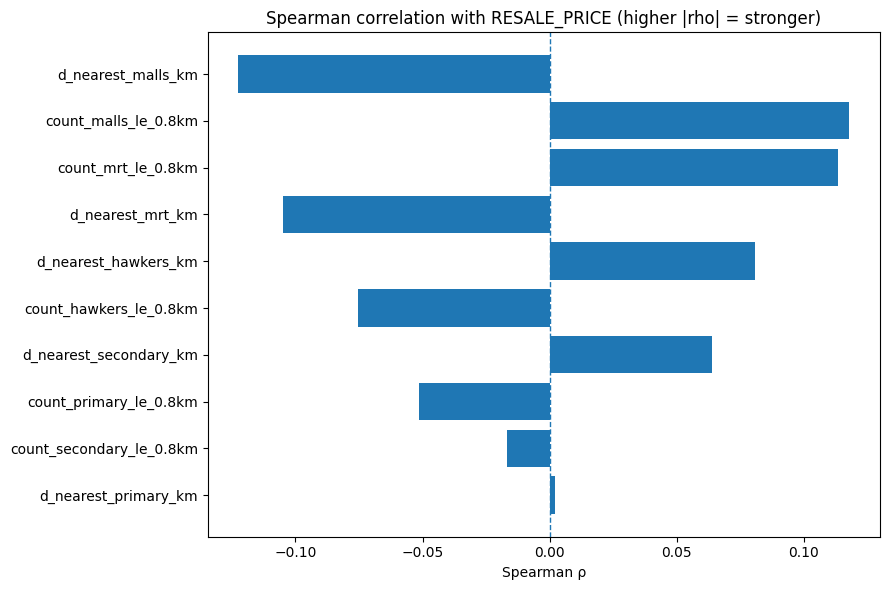

In [34]:

primary = pd.read_csv(data_dir / "auxiliary-data/sg-primary-schools.csv")
secondary = pd.read_csv(data_dir / "auxiliary-data/sg-secondary-schools.csv")
malls = pd.read_csv(data_dir / "auxiliary-data/sg-shopping-malls.csv")
hawkers = pd.read_csv(data_dir / "auxiliary-data/sg-gov-hawkers.csv")
mrt = pd.read_csv(data_dir / "auxiliary-data/sg-mrt-stations.csv")

poi_dict = {
    "primary": primary,
    "secondary": secondary,
    "malls": malls,
    "hawkers": hawkers,
    "mrt" : mrt
}

# 2) Build features (pick radii; k_nearest=1 or 3 to smooth)
# only 1 radius: 0.8 used to simplify the comparison while being pragmatic(0.8 ~ 12min of walking)
train_feat = add_geo_features(df_train, poi_dict, radii_km=(0.8,), k_nearest=1)

# (Optional) Light cleaning for EDA
# clip extreme distances (winsorize)
for c in [c for c in train_feat.columns if c.startswith("d_nearest_")]:
    train_feat[c] = train_feat[c].clip(upper=8.0)

# 3) Compute Spearman correlations vs price
corr_df = spearman_corr_vs_price(train_feat, target="RESALE_PRICE")

# 4) Plot strongest signals
plot_spearman_correlations(corr_df, top_n=16)
